In [32]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from functools import partial

In [41]:
# constants
NUM_OF_ARMS = 10
NUM_OF_STEPS = 1000
NUM_OF_RUNS = 2000

In [34]:
# environment implementation
class KArmedBandit:

    def __init__(self):
        self.reward = np.random.randn(NUM_OF_ARMS)
        self.optimal_choice = np.argmax(self.reward)

    def step(self, action):
        return self.reward[action] + np.random.randn()

In [35]:
# greedy agent implementation
class GreedyAgent:

    def __init__(self, epsilon):
        self.q_estimation = np.zeros(NUM_OF_ARMS)
        self.epsilon = epsilon
        self.action_counts = np.zeros(NUM_OF_ARMS)
    
    def act(self):
        if np.random.rand() < self.epsilon: action = np.random.choice(np.arange(NUM_OF_ARMS))
        else: action = np.argmax(self.q_estimation)
        self.action_counts[action] += 1
        return action
    
    def learn(self, action, reward):
        self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_counts[action]

In [36]:
# optimistic agent implementation
class InitialAgent:

    def __init__(self, initial, alpha=0.1):
        self.q_estimation = np.zeros(NUM_OF_ARMS) + initial
        self.alpha = alpha
    
    def act(self):
        action = np.argmax(self.q_estimation)
        return action
    
    def learn(self, action, reward):
        self.q_estimation[action] += self.alpha * (reward - self.q_estimation[action])

In [37]:
# ucb agent implementation
class UCBAgent:

    def __init__(self, c=0):
        self.q_estimation = np.zeros(NUM_OF_ARMS)
        self.const = c
        self.time = 0
        self.action_counts = np.zeros(NUM_OF_ARMS)
    
    def act(self):
        action = np.argmax(self.q_estimation + self.const * np.sqrt(np.log(self.time + 1) / (self.action_counts + 1e-5)))
        self.time += 1
        self.action_counts[action] += 1
        return action
    
    def learn(self, action, reward):
        self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_counts[action]

In [38]:
# gradient bandit implementation
class GradAgent:

    def __init__(self, alpha=0.1):
        self.q_estimation = np.zeros(NUM_OF_ARMS)
        self.alpha = alpha
        self.time = 0
        self.average_reward = 0

    def act(self):
        self.action_probabilities = np.exp(self.q_estimation) / np.sum(np.exp(self.q_estimation))
        action = np.random.choice(np.arange(NUM_OF_ARMS), p=self.action_probabilities)
        self.time += 1
        return action
    
    def learn(self, action, reward):
        self.average_reward += (reward - self.average_reward) / self.time
        one_hot = np.zeros(NUM_OF_ARMS)
        one_hot[action] = 1
        self.q_estimation += self.alpha * (reward - self.average_reward) * (one_hot - self.action_probabilities)


In [39]:
# run tests
def run(agents):
    rewards = np.zeros((len(agents), NUM_OF_STEPS))
    for i, agent in enumerate(agents):
        env = KArmedBandit()
        for step in np.arange(NUM_OF_STEPS):
            action = agent.act()
            reward = env.step(action)
            agent.learn(action, reward)
            rewards[i, step] = reward
    return rewards

In [42]:
# generate results 
greedy_params = np.arange(-7, -1)
initial_params = np.arange(-2, 3)
ucb_params = np.arange(-4, 3)
gradient_params = np.arange(-5, 2)

greedy_agents = [GreedyAgent(epsilon = 2.0**p) for p in greedy_params]
initial_agents = [InitialAgent(initial = 2.0**p) for p in initial_params]
ucb_agents = [UCBAgent(c = 2.0**p) for p in ucb_params]
gradient_agents = [GradAgent(alpha = 2.0**p) for p in gradient_params]

greedy_rewards = Parallel(n_jobs=6)(delayed(partial(run, greedy_agents))() for _ in range(NUM_OF_RUNS))
initial_rewards = Parallel(n_jobs=6)(delayed(partial(run, initial_agents))() for _ in range(NUM_OF_RUNS))
ucb_rewards = Parallel(n_jobs=6)(delayed(partial(run, ucb_agents))() for _ in range(NUM_OF_RUNS))
gradient_rewards = Parallel(n_jobs=6)(delayed(partial(run, gradient_agents))() for _ in range(NUM_OF_RUNS))

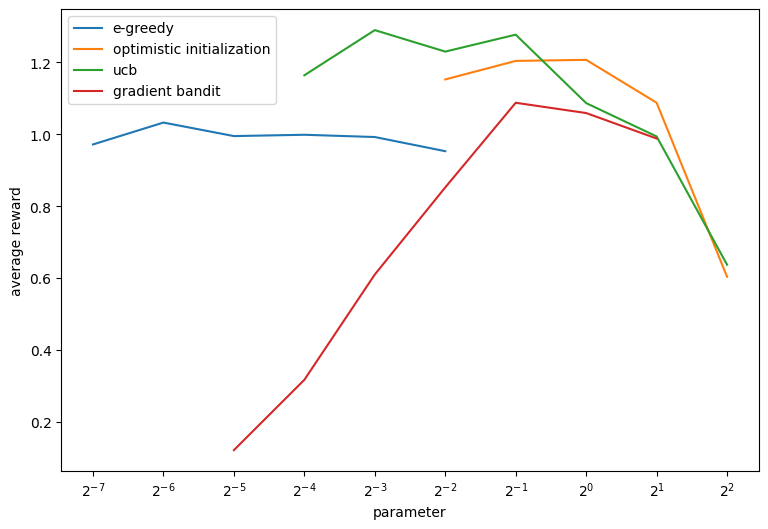

In [43]:
# generate figure 2.6
avg_greedy_rewards = np.mean(np.mean(greedy_rewards, axis=0), axis=1)
avg_initial_rewards = np.mean(np.mean(initial_rewards, axis=0), axis=1)
avg_ucb_rewards = np.mean(np.mean(ucb_rewards, axis=0), axis=1)
avg_gradient_rewards = np.mean(np.mean(gradient_rewards, axis=0), axis=1)

plt.figure(figsize=(9, 6))

plt.plot(greedy_params, avg_greedy_rewards, label='e-greedy')
plt.plot(initial_params, avg_initial_rewards, label='optimistic initialization')
plt.plot(ucb_params, avg_ucb_rewards, label='ucb')
plt.plot(gradient_params, avg_gradient_rewards, label='gradient bandit')

params = np.arange(-7, 3)
plt.xticks(params, [f'$2^{{{p}}}$' for p in params])
plt.xlabel('parameter')
plt.ylabel('average reward')
plt.legend()

plt.show()